In [10]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output
import re
import skopt
from skopt import BayesSearchCV
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.plots import plot_histogram, plot_objective_2D
from skopt.utils import use_named_args
from tqdm import tqdm
#!pip install scikit-optimize

In [12]:
#if starting from preprocess, load the drugs directly
df = pd.read_csv('../data/NP_FAERS_mapped_20220215.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5358 entries, 0 to 5357
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   FAERS_drug_match  5358 non-null   object
 1   lookup_value      5358 non-null   object
dtypes: object(2)
memory usage: 83.8+ KB


In [13]:
#make all casing upper
df['FAERS_drug_match'] = df['FAERS_drug_match'].str.upper()
df['lookup_value'] = df['lookup_value'].str.upper()

In [14]:
import tensorflow as tf
import string
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [15]:
# how i add noise 
# string w 
# proportion of noise added 
# uniform random from [0,1]
# if <1/3 edit one position with new random character, else if <2/3 delete one position, else add one random character 
def add_noise(w, percent):
  ''' edit, del, add'''
  positions = random.choices(range(len(w)), k=int(percent*len(w)))
  for p in positions:
    r = random.random()
    if r <= 0.3333: # edit
      w = w[:p] + random.choice(string.ascii_uppercase) + w[p+1:]
    elif r<= 0.6667: # delete
      w = w[:p] + w[p+1:]
    elif r<=1: # add
      w = w[:p] + random.choice(string.ascii_uppercase) + w[p:]
  return w

def clean(text):
    #remove all non-ascii, special characters and keep alphabets and space only. Can also use isalpha()
    #convert to uppercase
    #remove extra spaces
    regex = re.compile('[^a-zA-Z ]')
    r = regex.sub('', text)
    result = re.sub(' +', ' ', r)
    result = result.strip()
    return result.upper()
def clean_dataset(data):
  x = []
  y = []
  for i in range(data.shape[0]):
    w = clean(data.FAERS_drug_match.iloc[i])
    v = clean(data.lookup_value.iloc[i])
    x.append(w)
    y.append(v)
  return x,y

def encode_dataset(x,y):
  encode_dict = {l:i+1 for i,l in enumerate(string.ascii_uppercase + " ")}
  Xtrain = [[encode_dict[m] for m in n] for n in x]
  Ytrain = [[encode_dict[m] for m in n] for n in y]
  return Xtrain, Ytrain

def clean_encode_padding(q, maxlen):
  q = clean(q)
  encode_dict = {l:i+1 for i,l in enumerate(string.ascii_uppercase + " ")}
  return tf.keras.preprocessing.sequence.pad_sequences(
    [encode_dict[m] for m in q] , padding="post", maxlen=maxlen)

def padding_dataset(X,Y,maxlen):
  padded_y = tf.keras.preprocessing.sequence.pad_sequences(
    Y, padding="post", maxlen=maxlen)
  padded_x = tf.keras.preprocessing.sequence.pad_sequences(
      X, padding="post", maxlen=maxlen)
  return padded_x, padded_y

def cosine_distance(vects):
    x, y = vects
    return 1-tf.reduce_sum(tf.multiply(x,y),axis=1, keepdims=True)/(tf.norm(x,axis=1,keepdims=True)*tf.norm(y,axis=1,keepdims=True))

def loss(margin=1):
    def contrastive_loss(y_true, y_pred):
        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

def plt_metric(history, metric, title, has_valid=True):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()


In [16]:
train, test = train_test_split(df, test_size=0.20, random_state=42)

In [17]:
train.shape

(4286, 2)

In [18]:
test.shape

(1072, 2)

In [19]:
#padding length = maxlen
maxlen = 400

In [20]:
xtest, ytest = clean_dataset(test)
Xtest, Ytest = encode_dataset(xtest,ytest)
padded_xTest, padded_yTest = padding_dataset(Xtest,Ytest,maxlen)

In [21]:
padded_xTest.shape

(1072, 400)

In [22]:
#without noise 
x, y = clean_dataset(train)

In [23]:
len(y)

4286

In [24]:
encode_dict = {l:i+1 for i,l in enumerate(string.ascii_uppercase + " ")}

In [25]:
Xtrain = [[encode_dict[m] for m in n] for n in x]
Ytrain = [[encode_dict[m] for m in n] for n in y]

In [26]:
print(len(Xtrain))
print(len(Ytrain))
np.unique(Ytrain).shape

4286
4286


C:\Users\tanup\AppData\Local\Continuum\anaconda3\envs\clock\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


(125,)

In [27]:
padded_y = tf.keras.preprocessing.sequence.pad_sequences(
    Ytrain, padding="post", maxlen=maxlen
)
padded_x = tf.keras.preprocessing.sequence.pad_sequences(
    Xtrain, padding="post", maxlen=maxlen
)

print(padded_y)

[[19  5 18 ...  0  0  0]
 [15 16  8 ...  0  0  0]
 [ 3  9 14 ...  0  0  0]
 ...
 [ 1 12 12 ...  0  0  0]
 [ 1 12 12 ...  0  0  0]
 [ 8  5 13 ...  0  0  0]]


In [28]:
len(encode_dict)

27

In [29]:
dUnique_df = pd.DataFrame(columns = ['dUnique_label','dUnique_seq', 'dUnique_seq_padded'])
dUnique_df['dUnique_label'] = np.unique(y)
dUnique_df.head()

,dUnique_label,dUnique_seq,dUnique_seq_padded
0,ACTAEA RACEMOSA,NaN,NaN
1,AESCULUS HIPPOCASTANUM,NaN,NaN
2,ALLIUM SATIVUM,NaN,NaN
3,ALOE VERA,NaN,NaN
4,ANGELICA SINENSIS,NaN,NaN


In [30]:
dUnique_seq_list = [[encode_dict[m] for m in n] for n in dUnique_df['dUnique_label'].tolist()]
len(dUnique_seq_list)

125

In [31]:
for i in range(len(dUnique_df.index)):
    dUnique_df.at[i, 'dUnique_seq'] = np.array(dUnique_seq_list[i])
dUnique_df.head()

,dUnique_label,dUnique_seq,dUnique_seq_padded
0,ACTAEA RACEMOSA,"[1, 3, 20, 1, 5, 1, 27, 18, 1, 3, 5, 13, 15, 1...",NaN
1,AESCULUS HIPPOCASTANUM,"[1, 5, 19, 3, 21, 12, 21, 19, 27, 8, 9, 16, 16...",NaN
2,ALLIUM SATIVUM,"[1, 12, 12, 9, 21, 13, 27, 19, 1, 20, 9, 22, 2...",NaN
3,ALOE VERA,"[1, 12, 15, 5, 27, 22, 5, 18, 1]",NaN
4,ANGELICA SINENSIS,"[1, 14, 7, 5, 12, 9, 3, 1, 27, 19, 9, 14, 5, 1...",NaN


In [33]:
#setup negative pairs
dfneg = pd.read_csv('../data/NP_FAERS_negative_pairs_20220222.csv')
dfneg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9242 entries, 0 to 9241
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   FAERS_drug_match  9242 non-null   object
 1   lookup_value      9242 non-null   object
dtypes: object(2)
memory usage: 144.5+ KB


In [34]:
#encode negative pairs and add padding
xneg, yneg = clean_dataset(dfneg)
Xneg, Yneg = encode_dataset(xneg,yneg)
padded_xneg, padded_yneg = padding_dataset(Xneg,Yneg,maxlen)

In [35]:
dUnique = tf.keras.preprocessing.sequence.pad_sequences(
    list(dUnique_df['dUnique_seq']), padding="post", maxlen=maxlen)

In [36]:
np_unique = dUnique_df.dUnique_label.tolist()
len(np_unique)

125

In [37]:
#add positive pairs
x1TrainRNN = []
x2TrainRNN = []
yTrainRNN = []
for i in range(len(padded_x)):
    yTrainRNN.append(1)
    x1TrainRNN.append(padded_x[i])
    x2TrainRNN.append(padded_y[i])
print(len(x1TrainRNN), len(x2TrainRNN), len(yTrainRNN))

4286 4286 4286


In [38]:
train_res = train.reset_index()
train_res.head()

,index,FAERS_drug_match,lookup_value
0,3956,SERENOA REPENS/SERENOA REPENS EXTRACT/SERENOA ...,SERENOA REPENS
1,4408,CORDYCEPS,OPHIOCORDYCEPS SINENSIS
2,120,CINNAMON (CINNAMOUM VERUM) (CAPSULES),CINNAMON
3,3311,CHROMIUM PICOLINATE WITH GREEN TEA,CAMELLIA SINENSIS
4,1921,BARLEY.,BARLEY GRASS


In [39]:
#take negative pairs from training data
faers_match = []
lookup = []
for i in range(len(train_res)):
    np_name = train_res.at[i, 'FAERS_drug_match']
    for j in random.choices(range(len(np_unique)), k=4):
        np_temp = np_unique[j]
        np_match = train_res.loc[train_res['FAERS_drug_match'] == np_name].lookup_value.tolist()
        if np_temp not in np_match:
            faers_match.append(np_name)
            lookup.append(np_temp)
len(faers_match)

16912

In [40]:
dfneg2 = pd.DataFrame(columns=['FAERS_drug_match', 'lookup_value'])
dfneg2['FAERS_drug_match'] = faers_match
dfneg2['lookup_value'] = lookup
xneg2, yneg2 = clean_dataset(dfneg2)
Xneg2, Yneg2 = encode_dataset(xneg2,yneg2)
padded_xneg2, padded_yneg2 = padding_dataset(Xneg2,Yneg2,maxlen)

In [41]:
##add negative pairs from training data
for j in range(len(padded_xneg2)):
    yTrainRNN.append(0)
    x1TrainRNN.append(padded_xneg2[j])
    x2TrainRNN.append(padded_yneg2[j])
print(len(x1TrainRNN), len(x2TrainRNN), len(yTrainRNN))

21198 21198 21198


In [42]:
##add negative pairs from reference set
for j in range(len(padded_xneg)):
    yTrainRNN.append(0)
    x1TrainRNN.append(padded_xneg[j])
    x2TrainRNN.append(padded_yneg[j])
print(len(x1TrainRNN), len(x2TrainRNN), len(yTrainRNN))

30440 30440 30440


In [43]:
for i in range(len(dUnique_df.index)):
    dUnique_df.at[i, 'dUnique_seq_padded'] = dUnique[i]
dUnique_df.head()

,dUnique_label,dUnique_seq,dUnique_seq_padded
0,ACTAEA RACEMOSA,"[1, 3, 20, 1, 5, 1, 27, 18, 1, 3, 5, 13, 15, 1...","[1, 3, 20, 1, 5, 1, 27, 18, 1, 3, 5, 13, 15, 1..."
1,AESCULUS HIPPOCASTANUM,"[1, 5, 19, 3, 21, 12, 21, 19, 27, 8, 9, 16, 16...","[1, 5, 19, 3, 21, 12, 21, 19, 27, 8, 9, 16, 16..."
2,ALLIUM SATIVUM,"[1, 12, 12, 9, 21, 13, 27, 19, 1, 20, 9, 22, 2...","[1, 12, 12, 9, 21, 13, 27, 19, 1, 20, 9, 22, 2..."
3,ALOE VERA,"[1, 12, 15, 5, 27, 22, 5, 18, 1]","[1, 12, 15, 5, 27, 22, 5, 18, 1, 0, 0, 0, 0, 0..."
4,ANGELICA SINENSIS,"[1, 14, 7, 5, 12, 9, 3, 1, 27, 19, 9, 14, 5, 1...","[1, 14, 7, 5, 12, 9, 3, 1, 27, 19, 9, 14, 5, 1..."


In [44]:
x1TrainRnnS, x1ValRnnS, x2TrainRnnS, x2ValRnnS, yTrainRnnS, yValRnnS = train_test_split(x1TrainRNN, x2TrainRNN, yTrainRNN, test_size=0.20, random_state=42)

## build model and hyperparameter tuning

In [45]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [46]:
def build_model(model_type, embedding_dim, num_rnn_node, num_dense_node, num_layer, activation_fn, learning_rate, optimizer, margin):
    input_x = tf.keras.layers.Input(maxlen)
    input_1 = tf.keras.layers.Input(maxlen)
    input_2 = tf.keras.layers.Input(maxlen)
    embedding = tf.keras.layers.Embedding(input_dim=28, output_dim=embedding_dim, mask_zero=True)
    x = embedding(input_x)
    
    if model_type == "lstm":
        x = tf.keras.layers.LSTM(num_rnn_node)(x)
    elif model_type=="gru":
        x = tf.keras.layers.GRU(num_rnn_node)(x)
 
    num = num_dense_node
    for _ in range(num_layer):
        x = tf.keras.layers.Dense(num, activation=activation_fn)(x)
        num /= 2
        
    embedding_network = tf.keras.Model(input_x, x)

    tower_1 = embedding_network(input_1)
    tower_2 = embedding_network(input_2)

    merge_layer = tf.keras.layers.Lambda(cosine_distance)([tower_1, tower_2])
    output_layer = tf.keras.layers.Dense(1, activation="sigmoid")(merge_layer)
    contr = tf.keras.Model(inputs=[input_1, input_2], outputs=output_layer)
    
    if optimizer == "Adam":
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer =="RMSprop":                
        opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    contr.compile(loss=loss(margin= margin), optimizer=opt, metrics=["accuracy"])
    return contr

In [47]:
dim_model = Categorical(categories=["lstm", "gru"], name="model_type")
dim_embedding = Integer(low=64, high=512, prior="log-uniform", base=2, name="embedding_dim")
dim_rnn_node = Integer(low=128, high=1024, prior="log-uniform", base=2, name="num_rnn_node")
dim_num_dense_nodes = Integer(low=64, high=512, prior="log-uniform", base=2, name="num_dense_node")
dim_num_layer = Integer(low=1, high=5, prior="uniform", name="num_layer")
dim_activation = Categorical(categories=['tanh', 'relu'], name="activation_fn")
dim_lr = Real(low=1e-5, high=1e-1, prior="log-uniform", base=10, name="learning_rate")
dim_opt = Categorical(categories=['Adam', 'RMSprop'], name="optimizer")
dim_margin = Real(low=1e-1, high=1, prior="uniform", name="margin")
dim_batch_size = Integer(low=4, high=64, prior="log-uniform", base=2, name="batch_size")
dims = [dim_model, dim_embedding, dim_rnn_node, dim_num_dense_nodes, dim_num_layer, dim_activation, dim_lr, dim_opt, dim_margin, dim_batch_size]
default_params = ["gru", 64, 128, 64, 2, "tanh", 1e-3, "RMSprop", 1, 32]

In [48]:
def log_dir_name(a):
    o = ""
    for n in a:
        o+= str(n)+"_"
    return o+".log"

In [49]:
@use_named_args(dimensions=dims)
def fitness(model_type, embedding_dim, num_rnn_node, num_dense_node, num_layer, activation_fn, learning_rate, optimizer, margin, batch_size):
    
    print("model:", model_type)
    print("embedding_dim:", embedding_dim)
    print("num_rnn_node:", num_rnn_node)
    print("num_dense_node:", num_dense_node)
    print("num_layer:", num_layer)
    print("activation_fn:", activation_fn)
    print("learning rate: {:.1e}".format(learning_rate))
    print("optimizer:", optimizer)
    print("margin:", margin)
    print("batch_size:", batch_size)

    model = build_model(model_type, embedding_dim, num_rnn_node, num_dense_node, num_layer, activation_fn, learning_rate, optimizer, margin)
    params = [model_type, embedding_dim, num_rnn_node, num_dense_node, num_layer, activation_fn, learning_rate, optimizer, margin, batch_size]
   
    history = model.fit(x=[np.array(x1TrainRnnS), np.array(x2TrainRnnS)],
                        y=np.array(yTrainRnnS, dtype=np.float32),
                        epochs=35,
                        batch_size=batch_size,
                        validation_data=([np.array(x1ValRnnS), np.array(x2ValRnnS)], np.array(yValRnnS, dtype=np.float32)),
                        )
    
    loss = history.history['val_loss'][-1]
    print("Val loss: {0:.6%}".format(loss))
    model_name = "_".join([str(a) for a in params]) + f"{str(loss).replace('.', '_')}.h5"
    model.save(f"exp3_model/{model_name}")
    del model    
    
    return loss

In [60]:
save_model = tf.keras.callbacks.ModelCheckpoint(
      filepath= "exp3_model/alstm" + "-{epoch:02d}-{val_loss:.2f}.hdf5",
      save_weights_only=True,
      monitor='val_loss',
      verbose=1,
      save_best_only=False)

In [63]:
@use_named_args(dimensions=dims)
def fitness2(model_type, embedding_dim, num_rnn_node, num_dense_node, num_layer, activation_fn, learning_rate, optimizer, margin, batch_size):
    
    print("model:", model_type)
    print("embedding_dim:", embedding_dim)
    print("num_rnn_node:", num_rnn_node)
    print("num_dense_node:", num_dense_node)
    print("num_layer:", num_layer)
    print("activation_fn:", activation_fn)
    print("learning rate: {:.1e}".format(learning_rate))
    print("optimizer:", optimizer)
    print("margin:", margin)
    print("batch_size:", batch_size)

    model = build_model(model_type, embedding_dim, num_rnn_node, num_dense_node, num_layer, activation_fn, learning_rate, optimizer, margin)
    params = [model_type, embedding_dim, num_rnn_node, num_dense_node, num_layer, activation_fn, learning_rate, optimizer, margin, batch_size]
   
    history = model.fit(x=[np.array(x1TrainRnnS), np.array(x2TrainRnnS)],
                        y=np.array(yTrainRnnS, dtype=np.float32),
#                         epochs=35,
                        epochs=50,
                        batch_size=batch_size,
                        validation_data=([np.array(x1ValRnnS), np.array(x2ValRnnS)], np.array(yValRnnS, dtype=np.float32)),
                        callbacks=[save_model])
    
    loss = history.history['val_loss'][-1]
    print("Val loss: {0:.6%}".format(loss))
    model_name = "_".join([str(a) for a in params]) + f"{str(loss).replace('.', '_')}.h5"
    model.save(f"exp3_model/{model_name}")
    del model    
    
    return loss

In [46]:
fitness(x=default_params)

model: gru
embedding_dim: 64
num_rnn_node: 128
num_dense_node: 64
num_layer: 2
activation_fn: tanh
learning rate: 1.0e-03
optimizer: RMSprop
margin: 1
batch_size: 32


2022-03-01 21:18:44.689736: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-01 21:18:44.691683: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:af:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-03-01 21:18:44.691776: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-03-01 21:18:44.691811: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-03-01 21:18:44.691834: I tensorflow/stream_e

Epoch 1/40


2022-03-01 21:18:56.833596: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-03-01 21:18:57.615030: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


759/762 [============================>.] - ETA: 0s - loss: 0.1394 - accuracy: 0.8616

KeyboardInterrupt: 

In [48]:
search_result = gp_minimize(func=fitness, dimensions=dims, acq_func='EI', n_calls=40, x0=default_params)

model: gru
embedding_dim: 64
num_rnn_node: 128
num_dense_node: 64
num_layer: 2
activation_fn: tanh
learning rate: 1.0e-03
optimizer: RMSprop
margin: 1
batch_size: 32
Epoch 1/35
762/762 [==============================] - 26s 21ms/step - loss: 0.1135 - accuracy: 0.8569 - val_loss: 0.0903 - val_accuracy: 0.8625
Epoch 2/35
762/762 [==============================] - 13s 17ms/step - loss: 0.0903 - accuracy: 0.8599 - val_loss: 0.0828 - val_accuracy: 0.8696
Epoch 3/35
762/762 [==============================] - 13s 18ms/step - loss: 0.0801 - accuracy: 0.8895 - val_loss: 0.0712 - val_accuracy: 0.9207
Epoch 4/35
762/762 [==============================] - 13s 18ms/step - loss: 0.0703 - accuracy: 0.9223 - val_loss: 0.0623 - val_accuracy: 0.9369
Epoch 5/35
762/762 [==============================] - 14s 18ms/step - loss: 0.0587 - accuracy: 0.9395 - val_loss: 0.0562 - val_accuracy: 0.9404
Epoch 6/35
762/762 [==============================] - 13s 18ms/step - loss: 0.0518 - accuracy: 0.9469 - val_loss: 

Epoch 5/35
1108/1108 [==============================] - 30s 27ms/step - loss: nan - accuracy: 0.8550 - val_loss: nan - val_accuracy: 0.8625
Epoch 6/35
1108/1108 [==============================] - 30s 27ms/step - loss: nan - accuracy: 0.8616 - val_loss: nan - val_accuracy: 0.8625
Epoch 7/35
1108/1108 [==============================] - 30s 27ms/step - loss: nan - accuracy: 0.8584 - val_loss: nan - val_accuracy: 0.8625
Epoch 8/35
1108/1108 [==============================] - 30s 27ms/step - loss: nan - accuracy: 0.8591 - val_loss: nan - val_accuracy: 0.8625
Epoch 9/35
1108/1108 [==============================] - 30s 27ms/step - loss: nan - accuracy: 0.8547 - val_loss: nan - val_accuracy: 0.8625
Epoch 10/35
1108/1108 [==============================] - 30s 27ms/step - loss: nan - accuracy: 0.8608 - val_loss: nan - val_accuracy: 0.8625
Epoch 11/35
1108/1108 [==============================] - 30s 27ms/step - loss: nan - accuracy: 0.8611 - val_loss: nan - val_accuracy: 0.8625
Epoch 12/35
1108/1

Epoch 26/35
3480/3480 [==============================] - 62s 18ms/step - loss: 0.0924 - accuracy: 0.8608 - val_loss: 0.0904 - val_accuracy: 0.8625
Epoch 27/35
3480/3480 [==============================] - 62s 18ms/step - loss: 0.0903 - accuracy: 0.8599 - val_loss: 0.0883 - val_accuracy: 0.8625
Epoch 28/35
3480/3480 [==============================] - 62s 18ms/step - loss: 0.0884 - accuracy: 0.8592 - val_loss: 0.0863 - val_accuracy: 0.8625
Epoch 29/35
3480/3480 [==============================] - 62s 18ms/step - loss: 0.0862 - accuracy: 0.8606 - val_loss: 0.0845 - val_accuracy: 0.8625
Epoch 30/35
3480/3480 [==============================] - 62s 18ms/step - loss: 0.0854 - accuracy: 0.8557 - val_loss: 0.0828 - val_accuracy: 0.8625
Epoch 31/35
3480/3480 [==============================] - 62s 18ms/step - loss: 0.0826 - accuracy: 0.8616 - val_loss: 0.0812 - val_accuracy: 0.8625
Epoch 32/35
3480/3480 [==============================] - 62s 18ms/step - loss: 0.0821 - accuracy: 0.8567 - val_loss: 0

Epoch 30/35
937/937 [==============================] - 23s 25ms/step - loss: 0.1389 - accuracy: 0.8583 - val_loss: 0.1371 - val_accuracy: 0.8625
Epoch 31/35
937/937 [==============================] - 23s 25ms/step - loss: 0.1366 - accuracy: 0.8610 - val_loss: 0.1349 - val_accuracy: 0.8625
Epoch 32/35
937/937 [==============================] - 23s 25ms/step - loss: 0.1346 - accuracy: 0.8595 - val_loss: 0.1328 - val_accuracy: 0.8625
Epoch 33/35
937/937 [==============================] - 23s 25ms/step - loss: 0.1326 - accuracy: 0.8575 - val_loss: 0.1308 - val_accuracy: 0.8625
Epoch 34/35
937/937 [==============================] - 23s 25ms/step - loss: 0.1305 - accuracy: 0.8586 - val_loss: 0.1287 - val_accuracy: 0.8625
Epoch 35/35
937/937 [==============================] - 23s 25ms/step - loss: 0.1284 - accuracy: 0.8611 - val_loss: 0.1268 - val_accuracy: 0.8625
Val loss: 12.677984%
model: gru
embedding_dim: 112
num_rnn_node: 144
num_dense_node: 88
num_layer: 4
activation_fn: relu
learning 

ValueError: ('`cell` should have a `call` method. The RNN was passed:', 224)

In [53]:
dims = [dim_model, dim_embedding, dim_rnn_node, dim_num_dense_nodes, dim_num_layer, dim_activation, dim_lr, dim_opt, dim_margin, dim_batch_size]
default_params = ["gru", 64, 128, 64, 2, "tanh", 1e-3, "RMSprop", 1, 32]
best_params = ["lstm", 256, 512, 256, 1, "tanh", 2e-4, "Adam", 0.8, 4]

In [64]:
fitness2(x=best_params)

model: lstm
embedding_dim: 256
num_rnn_node: 512
num_dense_node: 256
num_layer: 1
activation_fn: tanh
learning rate: 2.0e-04
optimizer: Adam
margin: 0.8
batch_size: 4
Epoch 1/50
6089/6089 [==============================] - 95s 14ms/step - loss: 0.0707 - accuracy: 0.8619 - val_loss: 0.0555 - val_accuracy: 0.8625

Epoch 00001: saving model to exp3_model/alstm-01-0.06.hdf5
Epoch 2/50
6089/6089 [==============================] - 84s 14ms/step - loss: 0.0529 - accuracy: 0.8632 - val_loss: 0.0542 - val_accuracy: 0.8625

Epoch 00002: saving model to exp3_model/alstm-02-0.05.hdf5
Epoch 3/50
6089/6089 [==============================] - 84s 14ms/step - loss: 0.0489 - accuracy: 0.8606 - val_loss: 0.0418 - val_accuracy: 0.8625

Epoch 00003: saving model to exp3_model/alstm-03-0.04.hdf5
Epoch 4/50
6089/6089 [==============================] - 82s 14ms/step - loss: 0.0415 - accuracy: 0.8727 - val_loss: 0.0368 - val_accuracy: 0.9107

Epoch 00004: saving model to exp3_model/alstm-04-0.04.hdf5
Epoch 5/5

KeyboardInterrupt: 

## build_model2   (build and load_weights)

In [115]:
def build_model2(model_type, embedding_dim, num_rnn_node, num_dense_node, num_layer, activation_fn, learning_rate, optimizer, margin):
    input_x = tf.keras.layers.Input(maxlen)
    input_1 = tf.keras.layers.Input(maxlen)
    input_2 = tf.keras.layers.Input(maxlen)
    embedding = tf.keras.layers.Embedding(input_dim=28, output_dim=embedding_dim, mask_zero=True)
    x = embedding(input_x)
    
    if model_type == "lstm":
        x = tf.keras.layers.LSTM(num_rnn_node)(x)
    elif model_type=="gru":
        x = tf.keras.layers.GRU(num_rnn_node)(x)
 
    num = num_dense_node
    for _ in range(num_layer):
        x = tf.keras.layers.Dense(num, activation=activation_fn)(x)
        num /= 2
        
    embedding_network = tf.keras.Model(input_x, x)

    tower_1 = embedding_network(input_1)
    tower_2 = embedding_network(input_2)

    merge_layer = tf.keras.layers.Lambda(cosine_distance)([tower_1, tower_2])
    output_layer = tf.keras.layers.Dense(1, activation="sigmoid")(merge_layer)
    contr = tf.keras.Model(inputs=[input_1, input_2], outputs=output_layer)
    
    if optimizer == "Adam":
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer =="RMSprop":                
        opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    contr.compile(loss=loss(margin= margin), optimizer=opt, metrics=["accuracy"])
    return contr


model = build_model2("lstm", 256, 512, 256, 1, "tanh", 2e-4, "Adam", 0.8)
# history = model.fit(x=[np.array(x1TrainRnnS), np.array(x2TrainRnnS)],
#                         y=np.array(yTrainRnnS, dtype=np.float32),
#                         epochs=30,
#                         batch_size=4,
#                         validation_data=([np.array(x1ValRnnS), np.array(x2ValRnnS)], np.array(yValRnnS, dtype=np.float32)))

In [ ]:
model.load_weights("alstm-22-0.01.hdf5")

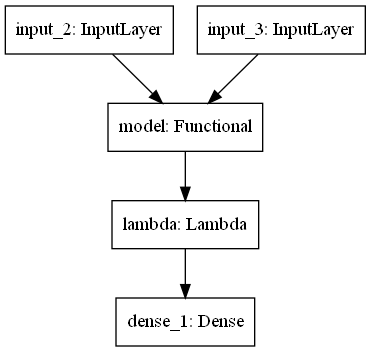

In [62]:

tf.keras.utils.plot_model(model)

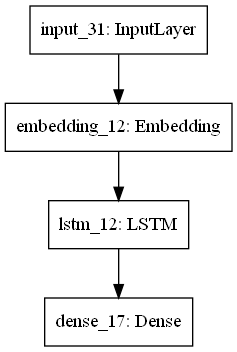

In [125]:
model2 = model.layers[2] 

tf.keras.utils.plot_model(model2)

In [127]:
model2.predict(dUnique)

array([[ 0.9209609 ,  0.9818054 , -0.55112475, ...,  0.9550037 ,
        -0.91177493,  0.33567536],
       [-0.32707602, -0.8085312 ,  0.36298504, ..., -0.5971373 ,
        -0.48414686, -0.7461844 ],
       [ 0.7975746 ,  0.911223  ,  0.97358453, ..., -0.9646154 ,
        -0.9465658 ,  0.87808084],
       ...,
       [ 0.91921526, -0.19321522, -0.48451972, ..., -0.26542348,
        -0.6002104 ,  0.9337821 ],
       [ 0.88084954, -0.8885829 , -0.93869764, ..., -0.851074  ,
        -0.9151342 , -0.74037963],
       [-0.829067  ,  0.98988235,  0.9152043 , ..., -0.9624905 ,
         0.5317913 , -0.9575233 ]], dtype=float32)